In [649]:
import excelreader
import numpy.random as rd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import ceil, floor
from copy import deepcopy

In [650]:
helper = excelreader.ProblemHelper()

Matrice originale des choix ordonnés par etudiant :
---------------------------------------------------
MAELLE ANDRICQUE........... :  1  2  2  1  2  1  2  3  1  3  2  3  1  3  3  3  1  1
OMAR KHALIFA ARIF.......... :  1  3  3  3  1  3  2  3  1  3  3  3  2  3  3  3  3  3
ALBANE ARTHUIS............. :  1  2  3  3  3  2  1  3  3  2  3  3  1  3  3  3  1  1
HOUSSAM BAHHOU............. :  3  3  3  2  3  2  1  3  1  1  3  1  3  1  2  3  3  3
LUCIE BANNAY............... :  3  3  3  2  3  3  2  3  3  3  3  3  3  3  3  3  1  3
REMI BARBOSA............... :  3  3  3  2  3  2  1  2  1  2  3  1  2  2  3  3  3  3
MARGOT BEAUREPAIRE......... :  3  3  3  2  2  3  2  2  2  1  3  1  3  1  3  3  2  2
BAPTISTE BENARD............ :  3  3  2  2  3  3  2  3  3  2  2  2  3  3  3  3  1  3
HAMZA BENMENDIL............ :  3  3  3  2  3  2  1  3  1  1  3  1  3  1  3  3  3  3
AYMERIC BLED............... :  2  3  3  1  3  1  2  2  1  1  2  2  3  1  3  3  3  3
ROMAIN BONNEFON............ :  3  3  3  3  3  2  2  2  2

In [651]:
id_industies = [1, 7]

In [652]:
# Avec les choix de malus ci dessous on souhaite avant tout pénaliser les groupes qui ne sont pas des 
# binômes quitte à ce que certains se voient attribuer leur choix numéro 3 

MALUS_GRP_0 = 1000
MALUS_GRP_1 = 1000
MALUS_GRP_3 = 1000
MALUS_GRP_4 = 500
MALUS_GRP_5SUP = 10000

MALUS_MIXITE = 300

MALUS_CHOICE_2 = 100
MALUS_CHOICE_3 = 400

MALUS_INDUSTRY = 10000

In [653]:
nbOfStudent = len(helper.matrixStudentNumberToName())
nbOfProject = len(helper.matrixProjectsNumberToName())

In [654]:
def getProjectChoiceByStudent(student, project):
    student_name = helper.matrixStudentNumberToName()[student]
    return helper._originalWishes[student_name][project]

In [655]:
def createRandomChromosome(nbOfStudent, nbOfProject):
    return [rd.randint(0,nbOfProject) for _ in range(nbOfStudent)]

def chromosomeChild(parent1, parent2):
    """
        Créé un nouveau chromosome en mélangeant les configurations de deux autres
    """
    aChromosome = []
    for i in range(len(parent1)):
        if(rd.random() > 0.5):
            aChromosome.append(parent1[i])
        else:
            aChromosome.append(parent2[i])
    return aChromosome

def chromosomeMutation(mutant, mutation_percent):
    """
        Modifie un chromosome.
        Attribue un projet aléatoire à deux personnes choisis aléatoirement
    """
    for _ in range(len(mutant)):
        if(rd.random() < mutation_percent):
            students = rd.randint(nbOfStudent, size=(2))
            projet = rd.randint(nbOfProject)
            mutant[students[0]] = projet
            mutant[students[1]] = projet

def computeFitness(aChromosome):
    fitness = 0

    occurence_proj = [[] for _ in range(nbOfProject)]
    for stud in range(len(aChromosome)):
        occurence_proj[aChromosome[stud]].append(helper._studentsGroup[stud])
    
    for proj in occurence_proj:
        # nombre d'étudiant par projet
        if len(proj) == 0: fitness += MALUS_GRP_0
        elif len(proj) == 1: fitness += MALUS_GRP_1
        elif len(proj) == 3:  fitness += MALUS_GRP_3
        elif len(proj) > 4: fitness += MALUS_GRP_5SUP
        # mixité
        fitness += abs(proj.count('EMMK') - proj.count('ENSC')) * MALUS_MIXITE

    # rang des projets pour chaque étudiant
    for stud in range(len(aChromosome)):
        studChoice = getProjectChoiceByStudent(stud, aChromosome[stud])
        if studChoice == 2: fitness += MALUS_CHOICE_2
        elif studChoice == 3 : fitness += MALUS_CHOICE_3
    
    return fitness

def orderByFitness(chromosomesWithFitness):
    return sorted(chromosomesWithFitness, key=lambda chromosome: chromosome[1])

In [656]:
NB_OF_CHROMOSOME = 100
NB_OF_LOOP = 2000

MUTATION_PERCENT = 0.1
TURNOVER = 0.5

Fitness finale: 7500 (obtenu à l'étape: 1585 sur 2000)


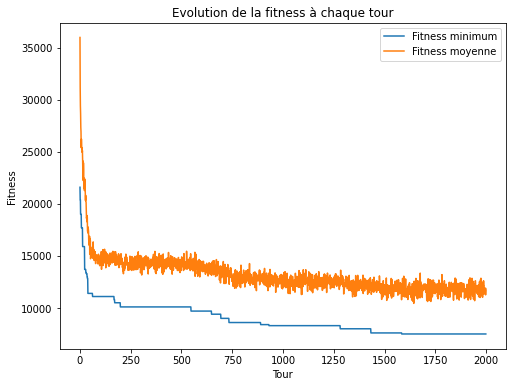

In [657]:
chromosomes = [createRandomChromosome(nbOfStudent, nbOfProject) for _ in range(NB_OF_CHROMOSOME)]
chromosomesWithFitness = [[chro, computeFitness(chro)] for chro in chromosomes]

best_genitor = int(NB_OF_CHROMOSOME/3)

evol = []
mean_evol = []
i_last = 0
best = chromosomesWithFitness[0][1]
for i in range(NB_OF_LOOP):
    
    # Liste des chromosomes ordonnées de la plus petite fitness à la plus grande
    chromosomesWithFitness = orderByFitness(chromosomesWithFitness)

    # Trace de d'évolution
    evol.append(chromosomesWithFitness[0][1])
    mean_evol.append(sum([chro[1] for chro in chromosomesWithFitness])/len(chromosomesWithFitness))
    if best > chromosomesWithFitness[0][1]:
        i_last = i
        best = chromosomesWithFitness[0][1]

    # Suppression des dernières chromosomes les moins pertinents
    nb_to_replace = int(NB_OF_CHROMOSOME*TURNOVER)
    chromosomesWithFitness = chromosomesWithFitness[0:NB_OF_CHROMOSOME-nb_to_replace]

    # Création de nouveau chromosome via deux méthodes
    newChromosome = []

    # on fusion deux chromosomes parmi les meilleurs pour en formé de nouveau (fusion)
    for _ in range(ceil(nb_to_replace/3)):
        parents = random.choices(chromosomesWithFitness[:best_genitor])[0][0], random.choices(chromosomesWithFitness[:best_genitor])[0][0]
        baby = chromosomeChild(*parents)
        newChromosome.append([baby, computeFitness(baby)])
    
    # on modifie aléatoirement la configiration d'un des meilleurs chromosomes (mutation) 
    for _ in range(floor(2*nb_to_replace/3)):
        aChromosome = random.choices(chromosomesWithFitness[:best_genitor])[0][0]
        mutant = deepcopy(aChromosome)
        chromosomeMutation(mutant, MUTATION_PERCENT)
        
        newChromosome.append([mutant, computeFitness(mutant)])
    
    chromosomesWithFitness.extend(newChromosome)

    if i % 100 == 0:
        print('\r', f"{i/NB_OF_LOOP*100:.1f}%", end="")

# Plot evolution
bestChromosome = chromosomesWithFitness[0]
bestConfig = bestChromosome[0]

print("\rFitness finale:", evol[-1], f"(obtenu à l'étape: {i_last} sur {NB_OF_LOOP})")

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.plot(range(NB_OF_LOOP), evol)
ax.plot(range(NB_OF_LOOP), mean_evol)
ax.legend(["Fitness minimum", "Fitness moyenne"])
ax.set_title("Evolution de la fitness à chaque tour")
ax.set_xlabel("Tour")
ax.set_ylabel("Fitness")
plt.show()

#### Plot best result 

C:\Users\paull\anaconda3\envs\tpsimon\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


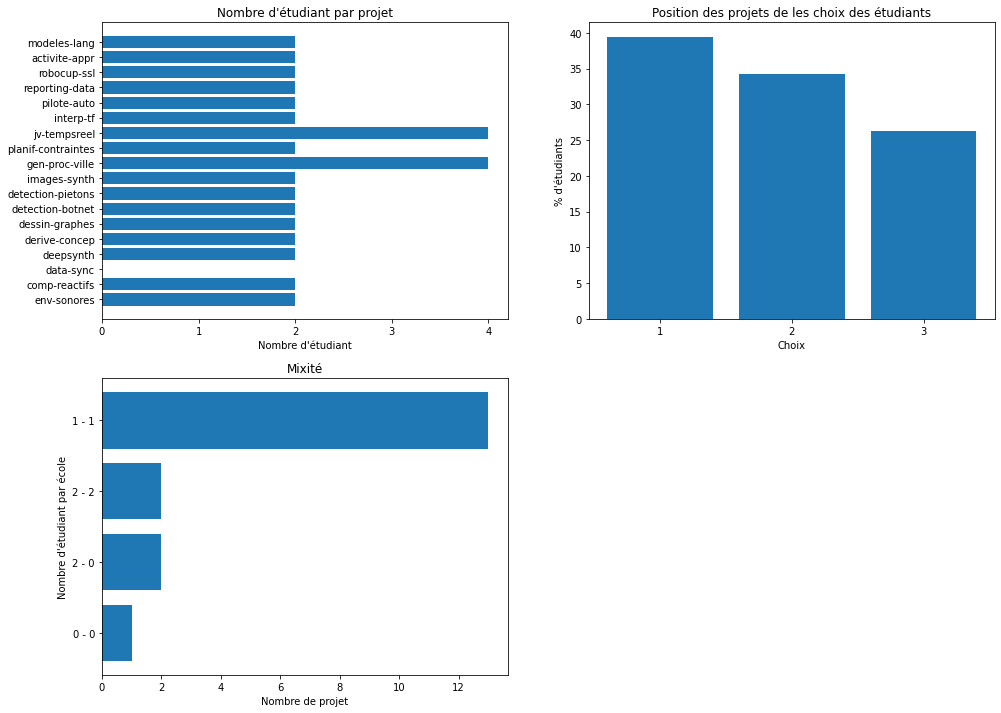

In [658]:
plt.figure(figsize=(16,12))

project, nb_stud = np.unique(bestConfig, return_counts=True)
nb_stud = [nb_stud[list(project).index(i)] if (i in project) else 0 for i in range(nbOfProject)]
project = list(range(nbOfProject))
ax = plt.subplot(221)
ax.barh(project, nb_stud)
ax.set_yticks(project, labels=helper.matrixProjectsNumberToName())
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel("Nombre d'étudiant")
ax.set_title("Nombre d'étudiant par projet")

original_choice = [getProjectChoiceByStudent(stud, proj) for stud, proj  in enumerate(bestConfig)]
choice, nbChoice = np.unique(original_choice, return_counts=True)
nbChoice = nbChoice/nbOfStudent * 100 # normalize
ax = plt.subplot(222)
ax.bar(choice, nbChoice)
ax.set_xticks(choice, labels=choice)
ax.set_ylabel("% d'étudiants")
ax.set_xlabel("Choix")
ax.set_title("Position des projets de les choix des étudiants")


occurence_proj = [[] for _ in range(nbOfProject)]
for stud in range(len(aChromosome)):
    occurence_proj[aChromosome[stud]].append(helper._studentsGroup[stud])

mixi, nb_mixi = np.unique(occurence_proj, return_counts=True)
mixity, nb_mixity = [], []
for mix, nb in zip(mixi, nb_mixi):
    neirb = mix.count("EMMK")
    nc = mix.count("ENSC")
    label = f"{max(nc, neirb)} - {min(neirb, nc)}"
    if label in mixity:
        nb_mixity[mixity.index(label)] += nb
    else:
        mixity.append(label)
        nb_mixity.append(nb)

ax = plt.subplot(223)
ax.barh(range(len(mixity)), nb_mixity)
ax.set_yticks(range(len(mixity)), labels=mixity)
ax.set_ylabel("Nombre d'étudiant par école")
ax.set_xlabel("Nombre de projet")
ax.set_title("Mixité")

plt.show()

In [659]:
config = deepcopy(bestConfig)
for i, projet in enumerate(helper.matrixProjectsNumberToName()):
    students = []
    while i in config:
        students.append(helper.matrixStudentNumberToName()[config.index(i)])
        config[config.index(i)] = -1
    
    print(f"{projet}: ", end="\t"*(2 - len(projet)//14))
    print(*students, sep="  -  ")

env-sonores: 		OMAR KHALIFA ARIF  -  ALBANE ARTHUIS
comp-reactifs: 		AGATHE MIGEON  -  HUGO PIERRE
data-sync: 		
deepsynth: 		JALAL IZEKKI  -  PIERRE PAVIA
derive-concep: 		IMAD BOUDROUA  -  SIMON LAUR
dessin-graphes: 	ALEXANDRE GISSAUD  -  VICTOR LEROY
detection-botnet: 	LUCIE BANNAY  -  AYMERIC BLED
detection-pietons: 	REMI BARBOSA  -  GUILHEM LE MOIGNE
images-synth: 		GAETAN MARGUERITTE  -  AMANDINE VALLEE
gen-proc-ville: 	HOUSSAM BAHHOU  -  MARGOT BEAUREPAIRE  -  JULIEN BRIAND  -  JULIAN DUPUIS
planif-contraintes: 	BAPTISTE BENARD  -  SELMANE LEBDAOUI
jv-tempsreel: 		HAMZA BENMENDIL  -  SOHAIB ERRABII  -  CORENTIN LANUSSE--MALHENE  -  ENORA THOMAS
interp-tf: 		EMMA NAVARRO  -  PATRICE ZHOU
pilote-auto: 		MOHAMED FAYCAL BOULLIT  -  MAEL LUCAS
reporting-data: 	PAUL LORGUE  -  YACINE NABET
robocup-ssl: 		LUCAS GUEDON  -  LOUIS LAVENSEAU
activite-appr: 		MARTIN DEVREESE  -  MOHAMED KOUHOU
modeles-lang: 		MAELLE ANDRICQUE  -  ROMAIN BONNEFON
